# Notebook Source Code

Code from my Kaggle account:
https://www.kaggle.com/kyledampier/ml-monday-week-4

Forked from (credit):
https://www.kaggle.com/uysimty/keras-cnn-dog-or-cat-classification

# Import Library

## Download Data

1. Go to https://www.kaggle.com/uysimty/keras-cnn-dog-or-cat-classification/data and download `train.zip` and `test1.zip` ~900MB
2. Copy files into `<Resources>/Lectures/Data`

In [1]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

# should contain test1.zip & train.zip
print(os.listdir("../Data/"))

['test1.zip', 'titanic_test.csv', 'titanic_train.csv', 'train.zip']


In [ ]:
import zipfile

def unzip_file(path_to_zip_file, directory_to_extract_to):
    with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
        zip_ref.extractall(directory_to_extract_to)

# change this if you want to extract the files to a different directory
unzip_file("../Data/train.zip", "./train")
unzip_file("../Data/test1.zip", "./test")


# Define Constants

In [2]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

# Prepare Traning Data

In [3]:
filenames = os.listdir("./train/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [4]:
df.head()

,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0


In [5]:
df.tail()

,filename,category
24995,dog.9995.jpg,1
24996,dog.9996.jpg,1
24997,dog.9997.jpg,1
24998,dog.9998.jpg,1
24999,dog.9999.jpg,1


### See Total In count

<AxesSubplot:>

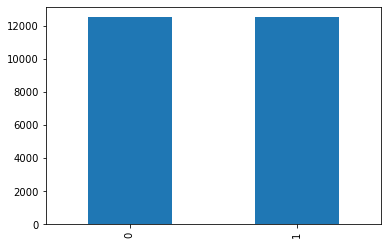

In [6]:
df['category'].value_counts().plot.bar()

From our data we have 12000 cats and 12000 dogs

# See sample image

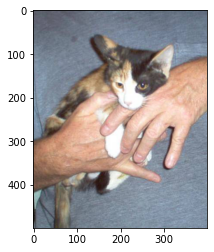

In [7]:
sample = random.choice(filenames)
image = load_img("./train/train/"+sample)
plt.imshow(image)

# Build Model

<img src="https://i.imgur.com/ebkMGGu.jpg" width="100%"/>

* **Input Layer**: It represent input image data. It will reshape image into single diminsion array. Example your image is 64x64 = 4096, it will convert to (4096,1) array.
* **Conv Layer**: This layer will extract features from image.
* **Pooling Layer**: This layerreduce the spatial volume of input image after convolution.
* **Fully Connected Layer**: It connect the network from a layer to another layer
* **Output Layer**: It is the predicted values layer. 

In [8]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

# https://keras.io/api/layers/convolution_layers/convolution2d/
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
#         Conv2D(<num_filters>, <kernel_size>) = 32 filters, 3x3 kernel -> 32 'feature maps'

# https://keras.io/api/layers/normalization_layers/batch_normalization/
model.add(BatchNormalization())
# https://keras.io/api/layers/pooling_layers/max_pooling2d/
model.add(MaxPooling2D(pool_size=(2, 2)))
# https://keras.io/api/layers/regularization_layers/dropout/
model.add(Dropout(0.25))

# https://keras.io/api/layers/activations/
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# https://keras.io/api/layers/reshaping_layers/flatten/
model.add(Flatten())
# https://keras.io/api/layers/core_layers/dense/
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

# 
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 64)       2

# Callbacks

In [9]:
# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

**Early Stop**

To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased

In [10]:
earlystop = EarlyStopping(patience=10) # https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

**Learning Rate Reduction**

We will reduce the learning rate when then accuracy not increase for 2 steps

In [11]:
# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', # name of the variable that plateaus (could be loss or accuracy)
                                            patience=2, # number of 'plateaus' before changing
                                            verbose=1, # print level (0 = nothing, 1 = everything)
                                            factor=0.5, # what to multiply by once plateau is reached (0.1 = 10% of original learning rate)
                                            min_lr=0.00001) # minimum learning rate


In [12]:
callbacks = [earlystop, learning_rate_reduction]

# Prepare data

Because we will use image genaretor `with class_mode="categorical"`. We need to convert column category into string. Then imagenerator will convert it one-hot encoding which is good for our classification. 

So we will convert 1 to dog and 0 to cat

In [13]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) # change the category column from 0 or 1 to 'cat' or 'dog'

In [14]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42) # split the data into training and testing
train_df = train_df.reset_index(drop=True) # reset the index so it goes from 0-len(train_df)
validate_df = validate_df.reset_index(drop=True) # reset the index so it goes from 0-len(validate_df)

<AxesSubplot:>

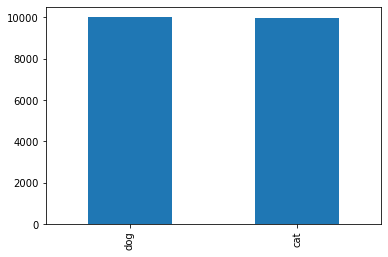

In [15]:
train_df['category'].value_counts().plot.bar()

<AxesSubplot:>

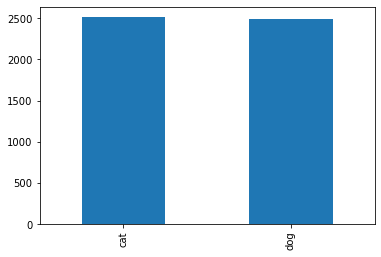

In [16]:
validate_df['category'].value_counts().plot.bar()

In [17]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15 # image data is loaded into memory in batches while training

# Traning Generator

In [18]:
train_datagen = ImageDataGenerator( # https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
    rotation_range=15, # randomly rotate images in the range (degrees, 0 to 180)
    rescale=1./255, # divide all values by 255 (to reduce the range of values to 0 to 1) aka NORMALIZE
    shear_range=0.1, # randomly apply shearing in the range (degrees, -10 to 10)
    zoom_range=0.2, # randomly apply scaling in the range (lower, upper)
    horizontal_flip=True,
    width_shift_range=0.1, # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1 # randomly shift images vertically (fraction of total height)
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, # Dataframe with training data (images and labels)
    "./train/train/", # directory containing training images
    x_col='filename', # column in dataframe that contains the image file paths
    y_col='category',  # column in dataframe that contains the image labels (cat or dog)
    target_size=IMAGE_SIZE, # resize images to IMAGE_SIZE(width, height)
    class_mode='categorical',  # change the output type
    batch_size=batch_size # number of images to load at a time
)


Found 20000 validated image filenames belonging to 2 classes.


### Validation Generator

In [19]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, # dataframe containing file names of validation images
    "./train/train/", # list of file names of validation images
    x_col='filename', # column name of filename in dataframe
    y_col='category', # column name of target in dataframe
    target_size=IMAGE_SIZE,
    class_mode='categorical', # change the output type (possible types: 'binary', 'categorical', 'sparse')
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


# See how our generator work

Load an example generator with n=1 images

In [20]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df,
    "./train/train/",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical' ,
)

Found 1 validated image filenames belonging to 1 classes.


## Show image randomizer

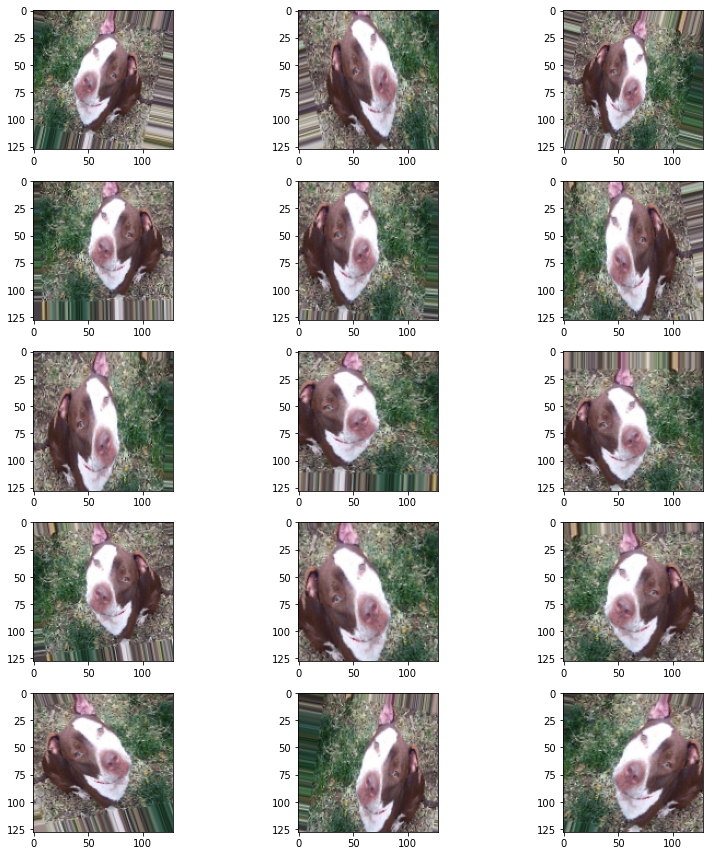

In [21]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

Seem to be nice 

# Fit Model

In [23]:
epochs=3 if FAST_RUN else 50
history = model.fit(
    train_generator, 
    epochs=epochs, # number of times to iterate over the data before validation
    validation_data=validation_generator, # data the model has never been trained on
    validation_steps=total_validate//batch_size, # number of times to iterate over the validation data
    steps_per_epoch=total_train//batch_size, # number of times to iterate over the training data
    callbacks=callbacks # list of callbacks to apply during training (efter or during each epoch)
)

Epoch 1/50
1333/1333 [==============================] - 85s 61ms/step - loss: 0.7458 - accuracy: 0.6337 - val_loss: 0.5466 - val_accuracy: 0.7191 - lr: 0.0010
Epoch 2/50
1333/1333 [==============================] - 81s 61ms/step - loss: 0.5691 - accuracy: 0.7124 - val_loss: 0.4736 - val_accuracy: 0.7654 - lr: 0.0010
Epoch 3/50
1333/1333 [==============================] - 82s 61ms/step - loss: 0.5151 - accuracy: 0.7511 - val_loss: 0.4580 - val_accuracy: 0.7936 - lr: 0.0010
Epoch 4/50
1333/1333 [==============================] - 82s 61ms/step - loss: 0.4737 - accuracy: 0.7754 - val_loss: 1.5671 - val_accuracy: 0.5910 - lr: 0.0010
Epoch 5/50
1333/1333 [==============================] - ETA: 0s - loss: 0.4466 - accuracy: 0.7985
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1333/1333 [==============================] - 82s 62ms/step - loss: 0.4466 - accuracy: 0.7985 - val_loss: 0.8210 - val_accuracy: 0.6621 - lr: 0.0010
Epoch 6/50
1333/1333 [================

# Save Model

We will learn how to edit models later

In [24]:
model.save_weights("model.h5")

# Virtualize Training

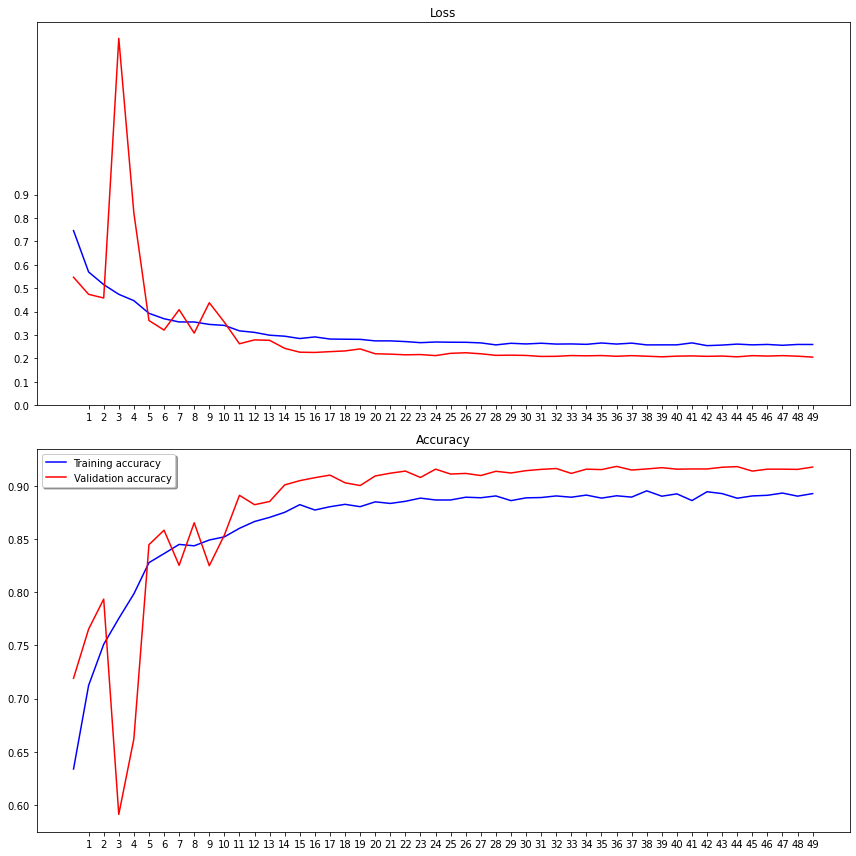

In [40]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))
ax1.set_title('Loss')

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))
ax2.set_title('Accuracy')

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# Prepare Testing Data

In [29]:
test_filenames = os.listdir("./test/test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

# Create Testing Generator

In [30]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "./test/test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


# Predict

In [31]:
predict = model.predict(test_generator, steps=np.ceil(nb_samples/batch_size))

C:\Users\kyle\AppData\Local\Temp/ipykernel_20716/3090721588.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))


For categoral classication the prediction will come with probability of each category. So we will pick the category that have the highest probability with numpy average max

In [32]:
test_df['category'] = np.argmax(predict, axis=-1)

We will convert the predict category back into our generator classes by using `train_generator.class_indices`. It is the classes that image generator map while converting data into computer vision

In [33]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

From our prepare data part. We map data with `{1: 'dog', 0: 'cat'}`. Now we will map the result back to dog is 1 and cat is 0

In [34]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

### Virtaulize Result

<AxesSubplot:>

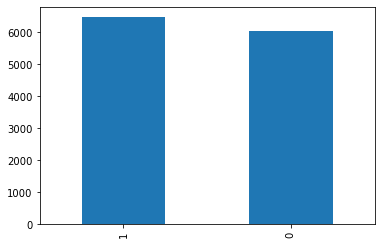

In [35]:
test_df['category'].value_counts().plot.bar()

### See predicted result with images

**1 = dog, 0 = cat**

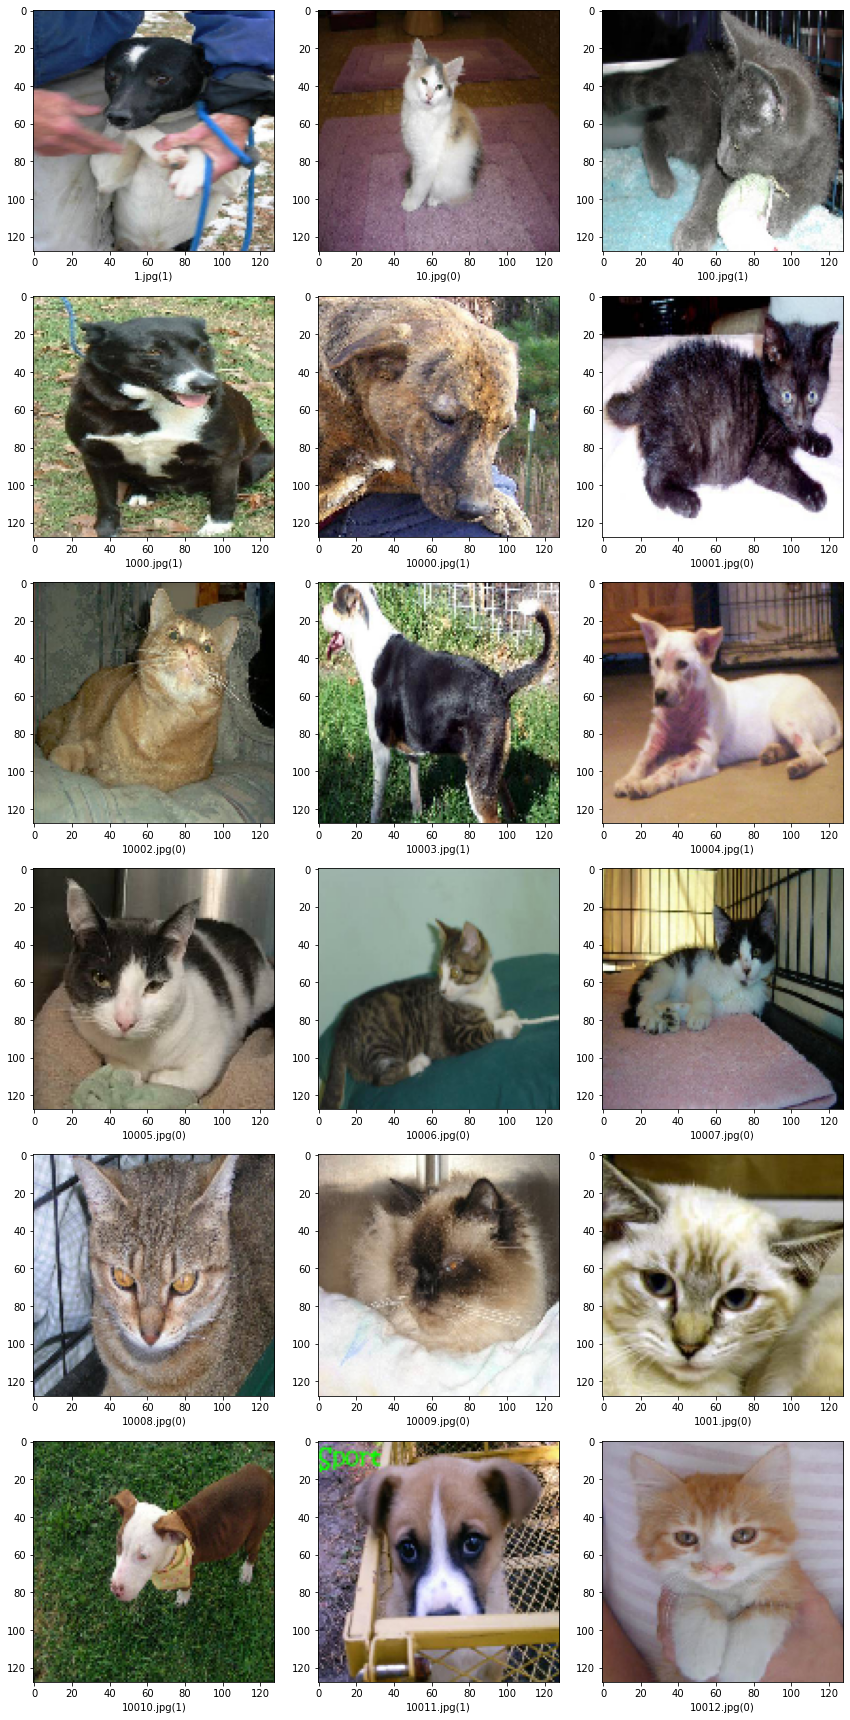

In [37]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("./test/test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

# Loading Pre-made Models

In [ ]:
from tensorflow import keras
model = keras.models.load_model('model.h5')

# VGG16

In [46]:
from keras.applications.vgg16 import VGG16
vvg_16 = VGG16(input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3), weights='imagenet', include_top=False)
print(vvg_16.summary())

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

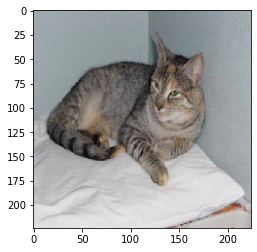

In [76]:
from keras.preprocessing.image import load_img # for loading images
# https://keras.io/api/applications/vgg/#vgg16-function
from keras.applications.vgg16 import VGG16
import random # for random number generation

# load the model
model = VGG16()
# load an image from file
# VVG16 model input size is 224x224
image = load_img(
    f"./test/test1/{random.randint(0, 1000)}.jpg", target_size=(224, 224))
plt.imshow(image)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


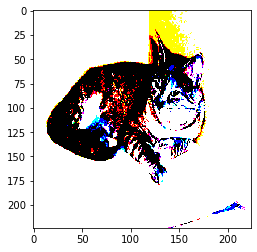

In [77]:
from keras.preprocessing.image import img_to_array

# convert the image pixels to a numpy array
image = img_to_array(image)
# reshape data for the model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# prepare the image for the VGG model
image = preprocess_input(image)
plt.imshow(image[0], interpolation='nearest')


In [80]:
from keras.applications.vgg16 import decode_predictions

# predict the probability across all output classes
yhat = model.predict(image)

yhat[0]


array([1.82959312e-07, 3.30222804e-07, 6.63644357e-07, 7.99055726e-07,
       1.34777409e-07, 1.23694974e-07, 6.01069630e-08, 2.74820849e-07,
       5.18421075e-07, 2.12321449e-08, 6.94072753e-07, 2.32416877e-08,
       8.23314281e-07, 7.45058287e-07, 3.78094072e-08, 6.81977963e-06,
       1.53350953e-07, 1.42109093e-06, 4.42959234e-08, 1.67289883e-07,
       3.80872194e-07, 4.02440833e-07, 2.48069405e-08, 1.61343667e-08,
       6.94868550e-06, 8.56689155e-08, 4.65724028e-08, 1.88678698e-07,
       6.46397709e-08, 1.14181100e-08, 4.68919325e-07, 1.78726182e-07,
       3.32495205e-07, 3.32712801e-07, 4.38970659e-07, 1.72418112e-07,
       1.02818240e-06, 2.74905369e-06, 1.48586935e-07, 1.18539720e-06,
       1.54660171e-07, 1.52683640e-07, 5.90273039e-08, 1.96865244e-07,
       2.52842779e-06, 1.40640651e-07, 1.32517096e-06, 2.26264419e-07,
       1.58802649e-07, 2.29140383e-07, 9.87495696e-07, 3.62771698e-06,
       2.05000489e-07, 2.26509272e-07, 1.73119611e-06, 8.81955060e-08,
      

In [81]:
from keras.applications.vgg16 import preprocess_input

# convert the probabilities to class labels
label = decode_predictions(yhat)
# retrieve the most likely result, e.g. highest probability
label = label[0][0]
# print the classification
print('%s (%.2f%%)' % (label[1], label[2]*100))


tabby (66.15%)
